<a href="https://colab.research.google.com/github/swathianil/NMA_deeplearning/blob/main/IFC_HCP_BrainGNNstandalone_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IFC Implementation of the BrainGNN model on the HCP Gambling Dataset**

Similar to the other BrainGNN notebook, but instead of using the gambling trials, this one classifies the fMRI tasks (WM, Motor, etc.) as in the paper. Took time series data from the first 150 frames to make the dimensions matched; shuffled each condition indpendantly so data from the same subjects was randomly shuffled and not concentrated in any single subset of the train/test/val split.


In [1]:
# @title Mount your Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# @title Install dependencies

# using that specific torch-geometric version is important; pooling layer does not
# have weights called the same way in the newest version
!pip install nilearn
!git clone https://github.com/xxlya/BrainGNN_Pytorch.git
!pip install tensorboardX
!pip install networkx
#!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch-geometric==1.7.1
import torch

#!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip uninstall torch-scatter torch-sparse torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
#!pip install git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 64.3 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2
Cloning into 'BrainGNN_Pytorch'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 82 (delta 7), reused 3 (delta 0), pack-reused 64
Receiving objects: 100% (82/82), 55.50 KiB | 9.25 MiB/s, done.
Resolving deltas: 100% (24/24), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
     ━━━━━━━━━━━━━━━━━━━━━

In [3]:
# @title Lot of imports
from torch_geometric.data import Data
from networkx.convert_matrix import from_numpy_array
import networkx as nx
from torch_geometric.utils import remove_self_loops
from torch_sparse import coalesce

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
import sys
import networkx as ntx

# package imports
!cd content/BrainGNN_Pytorch
import argparse
import time
import copy
from nilearn import connectome

import torch
import torch.nn.functional as F
from torch.optim import lr_scheduler
from tensorboardX import SummaryWriter

#from torch_geometric.data import DataLoader
#from net.braingnn import Network
#from imports.utils import train_val_test_split
from sklearn.metrics import classification_report, confusion_matrix

/bin/bash: line 1: cd: content/BrainGNN_Pytorch: No such file or directory


In [4]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# @title Dictionaries for data

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-grained conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win','loss_event','win_event','neut_event']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}



> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [6]:
# @title Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
    )

In [7]:
# @title Function to load time series data
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

def load_evs_dir(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/"
  stuff = os.listdir(ev_file)
  return stuff

def load_evs_beh(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/neut_event.txt"
  return ev_file

In [8]:
# @title Function to compute connectivity matrices function

def subject_connectivity(timeseries, kind, iter_no='', seed=1234,
                         n_subjects=''):
    """
        timeseries   : timeseries table for subject (timepoints x regions)
        subjects     : subject IDs
        kind         : the kind of connectivity to be used, e.g. lasso, partial correlation, correlation
        iter_no      : tangent connectivity iteration number for cross validation evaluation
    returns:
        connectivity : connectivity matrix (regions x regions)
    """

    if kind in ['TPE', 'TE', 'correlation','partial correlation']:
        if kind not in ['TPE', 'TE']:
            conn_measure = connectome.ConnectivityMeasure(kind=kind)
            connectivity = conn_measure.fit_transform(timeseries)
        else:
            if kind == 'TPE':
                conn_measure = connectome.ConnectivityMeasure(kind='correlation')
                conn_mat = conn_measure.fit_transform(timeseries)
                conn_measure = connectome.ConnectivityMeasure(kind='tangent')
                connectivity_fit = conn_measure.fit(conn_mat)
                connectivity = connectivity_fit.transform(conn_mat)
            else:
                conn_measure = connectome.ConnectivityMeasure(kind='tangent')
                connectivity_fit = conn_measure.fit(timeseries)
                connectivity = connectivity_fit.transform(timeseries)


        if kind not in ['TPE', 'TE']:
            return connectivity
        else:
            return connectivity_fit

In [9]:
# @title Loop through all subjects; average timeseries for conditions
print(range(N_SUBJECTS))
data_pull = []
for i in range(N_SUBJECTS):
  subject_pull = subjects[i]
  exp_hold = []
  for key in EXPERIMENTS:
    run_hold = []
    for j in range(len(RUNS)):
      bold_path = f"{HCP_DIR}/subjects/{subject_pull}/{key}/tfMRI_{key}_{RUNS[j]}"
      bold_file = "data.npy"
      ts = np.load(f"{bold_path}/{bold_file}")
      ts = ts[:,0:150]
      run_hold.append(ts)
    exp_hold = np.mean(np.asarray(run_hold), axis = 0)
    data_pull.append(exp_hold.T)

range(0, 100)


In [10]:
# @title Normalize data by z-score`
from scipy import stats
# norm by z-score, I think
norm = stats.zscore(data_pull, axis=2)
#norm = data_pull

In [11]:
# @title  Compute and save connectivity matrices
#corr = subject_connectivity(timeseries = data_pull, subjects = np.expand_dims(subjects, axis = 1), kind = 'correlation')
#part_corr = subject_connectivity(timeseries = data_pull, subjects = np.expand_dims(subjects, axis = 1), kind = 'partial correlation')
# Compute and save connectivity matrices
corr = subject_connectivity(timeseries = norm, kind = 'correlation')
part_corr = subject_connectivity(timeseries = norm, kind = 'partial correlation')

/usr/local/lib/python3.10/dist-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
/usr/local/lib/python3.10/dist-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
/usr/local/lib/python3.10/dist

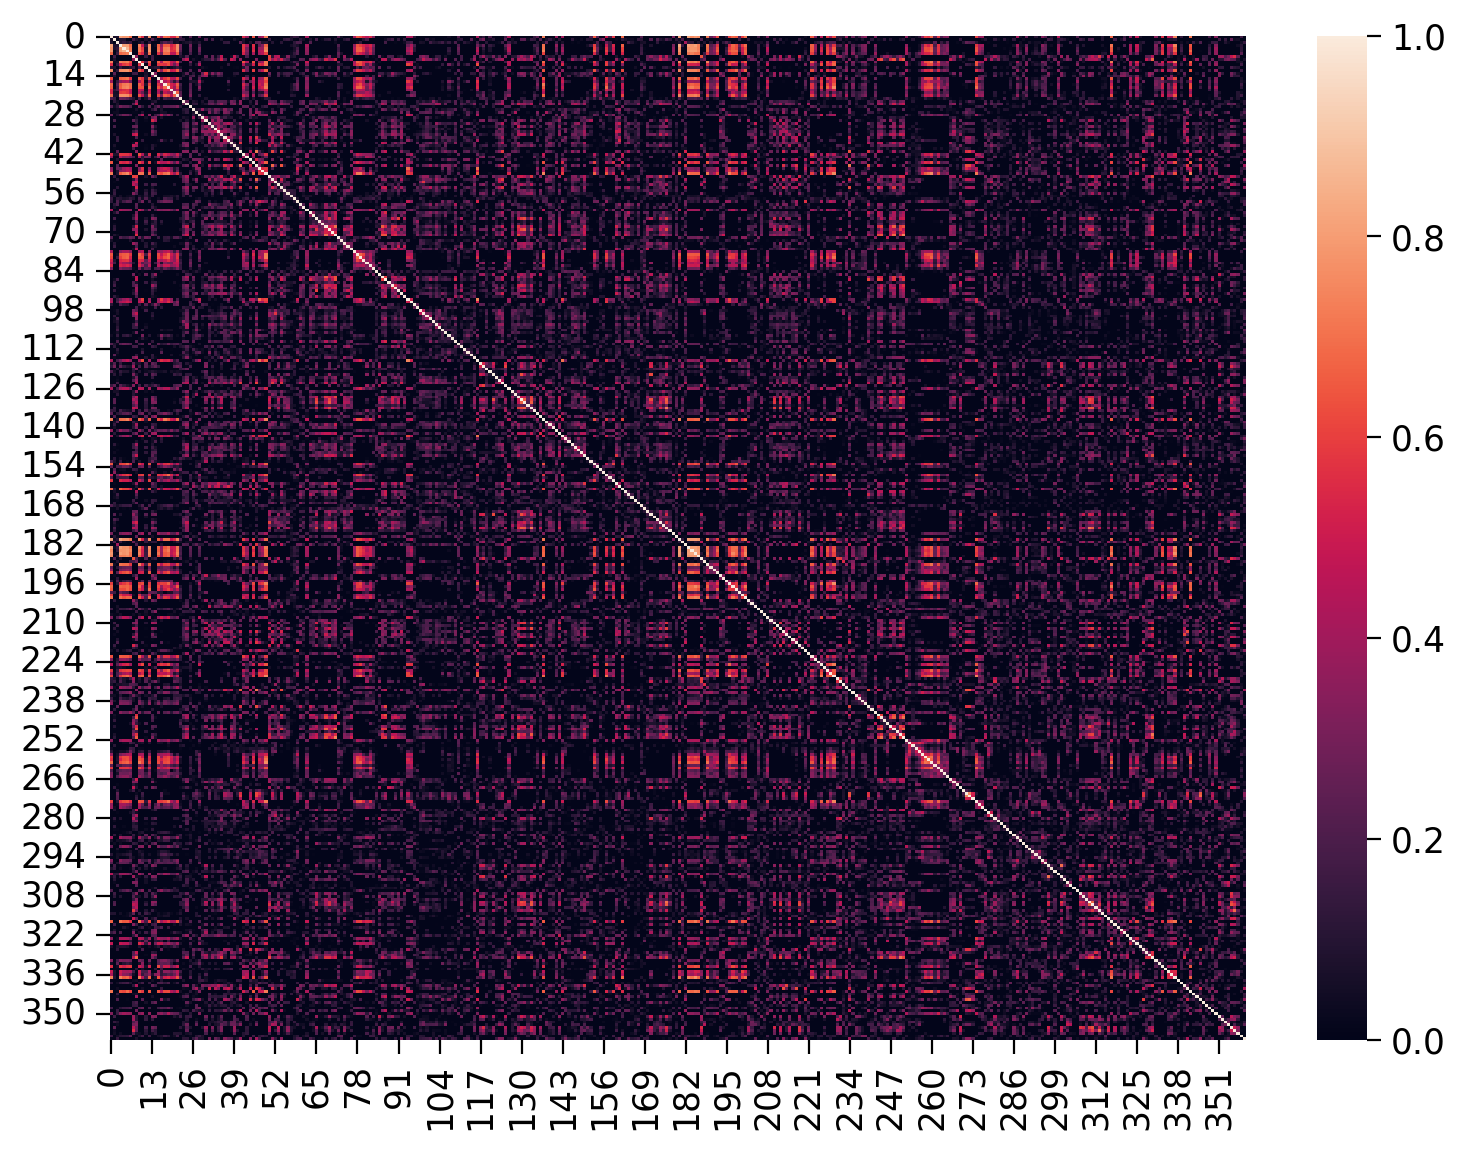

In [12]:
# @title Corr heatmaps if you want to look at them`
ax = sns.heatmap(corr[5,:,:], vmin=0, vmax=1)
plt.show()

In [13]:
# @title Create list of graphs; high RAM usage step
# heavily adapted code from GNN package: https://github.com/xxlya/BrainGNN_Pytorch/blob/main/imports/read_abide_stats_parall.py
# turns single set of matrices into a data graph using torch_geomtetric; appends
# each one as it's created to a list named "Graph"

from torch_geometric.data import Data
from networkx.convert_matrix import from_numpy_array
import networkx as nx
from torch_geometric.utils import remove_self_loops
from torch_sparse import coalesce

# labels list
labels_vec = list(range(7))*100

# no idea if the position data is correct
#pseudo = np.ones([360,360])
pseudo = np.eye(360)
pseudo = torch.from_numpy(pseudo).float()
Graphs = []
for j in range(len(data_pull)):
  corr_full = corr[j,:,:]
  pcorr = part_corr[j,:,:]
  num_nodes = pcorr.shape[0]
  G = from_numpy_array(pcorr)
  A = nx.to_scipy_sparse_array(G)
  adj = A.tocoo()
  edge_att = np.zeros(len(adj.row))

  for i in range(len(adj.row)):
    edge_att[i] = pcorr[adj.row[i], adj.col[i]]

  edge_index = np.stack([adj.row, adj.col])
  edge_index, edge_att = remove_self_loops(torch.from_numpy(edge_index).float(), torch.from_numpy(edge_att).float())
  edge_index = edge_index.long()
  edge_index, edge_att = coalesce(edge_index, edge_att, num_nodes,
                                      num_nodes)
  # don't know the best way to rep the labels, tbd
  label = labels_vec[j]

  att_torch = torch.from_numpy(corr_full).float()
  y_torch = torch.from_numpy(np.array(label)).long()  # classification

  Graphs.append(Data(x=att_torch, edge_index=edge_index, y=y_torch, edge_attr=edge_att, pos = pseudo))

In [26]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

DEVICE = set_device()

GPU is enabled in this notebook.


In [27]:
# @title Set parameters for the model; re-run this chunk before any run to reset the initial learning rate

torch.manual_seed(123)

EPS = 1e-10
device = DEVICE
print(device)

parser = argparse.ArgumentParser()
parser.add_argument('--epoch', type=int, default=0, help='starting epoch')
parser.add_argument('--n_epochs', type=int, default=100, help='number of epochs of training')
parser.add_argument('--batchSize', type=int, default=50, help='size of the batches')
parser.add_argument('--dataroot', type=str, default='drive/MyDrive/NMA', help='root directory of the dataset')
parser.add_argument('--fold', type=int, default=0, help='training which fold')
parser.add_argument('--lr', type = float, default=0.01, help='learning rate')
parser.add_argument('--stepsize', type=int, default=20, help='scheduler step size')
parser.add_argument('--gamma', type=float, default=0.5, help='scheduler shrinking rate')
parser.add_argument('--weightdecay', type=float, default=5e-3, help='regularization')
parser.add_argument('--lamb0', type=float, default=1, help='classification loss weight')
parser.add_argument('--lamb1', type=float, default=0, help='s1 unit regularization')
parser.add_argument('--lamb2', type=float, default=0, help='s2 unit regularization')
parser.add_argument('--lamb3', type=float, default=0.1, help='s1 entropy regularization')
parser.add_argument('--lamb4', type=float, default=0.1, help='s2 entropy regularization')
parser.add_argument('--lamb5', type=float, default=0.1, help='s1 consistence regularization')
parser.add_argument('--layer', type=int, default=7, help='number of GNN layers')
parser.add_argument('--ratio', type=float, default=0.5, help='pooling ratio')
parser.add_argument('--indim', type=int, default=360, help='feature dim')
parser.add_argument('--nroi', type=int, default=360, help='num of ROIs')
parser.add_argument('--nclass', type=int, default=7, help='num of classes')
parser.add_argument('--load_model', type=bool, default=False)
parser.add_argument('--save_model', type=bool, default=False)
parser.add_argument('--optim', type=str, default='Adam', help='optimization method: SGD, Adam')
parser.add_argument('--save_path', type=str, default='./model/', help='path to save model')
opt = parser.parse_args([])

#################### Parameter Initialization #######################
path = opt.dataroot
name = 'hcp'
save_model = opt.save_model
load_model = opt.load_model
opt_method = opt.optim
num_epoch = opt.n_epochs
fold = opt.fold
writer = SummaryWriter(os.path.join('./log',str(fold)))

cuda


In [28]:
# @title Inits
# net inits
import math


def uniform(size, tensor):
    bound = 1.0 / math.sqrt(size)
    if tensor is not None:
        tensor.data.uniform_(-bound, bound)


def kaiming_uniform(tensor, fan, a):
    if tensor is not None:
        bound = math.sqrt(6 / ((1 + a**2) * fan))
        tensor.data.uniform_(-bound, bound)


def glorot(tensor):
    if tensor is not None:
        stdv = math.sqrt(6.0 / (tensor.size(-2) + tensor.size(-1)))
        tensor.data.uniform_(-stdv, stdv)


def zeros(tensor):
    if tensor is not None:
        tensor.data.fill_(0)


def ones(tensor):
    if tensor is not None:
        tensor.data.fill_(1)

In [29]:
# @title Message passing for the network
import sys
import inspect

import torch
#from torch_geometric.utils import scatter
from torch_scatter import scatter,scatter_add

special_args = [
    'edge_index', 'edge_index_i', 'edge_index_j', 'size', 'size_i', 'size_j'
]
__size_error_msg__ = ('All tensors which should get mapped to the same source '
                      'or target nodes must be of same size in dimension 0.')

is_python2 = sys.version_info[0] < 3
getargspec = inspect.getargspec if is_python2 else inspect.getfullargspec


class MyMessagePassing(torch.nn.Module):
    r"""Base class for creating message passing layers
    .. math::
        \mathbf{x}_i^{\prime} = \gamma_{\mathbf{\Theta}} \left( \mathbf{x}_i,
        \square_{j \in \mathcal{N}(i)} \, \phi_{\mathbf{\Theta}}
        \left(\mathbf{x}_i, \mathbf{x}_j,\mathbf{e}_{i,j}\right) \right),
    where :math:`\square` denotes a differentiable, permutation invariant
    function, *e.g.*, sum, mean or max, and :math:`\gamma_{\mathbf{\Theta}}`
    and :math:`\phi_{\mathbf{\Theta}}` denote differentiable functions such as
    MLPs.
    See `here <https://pytorch-geometric.readthedocs.io/en/latest/notes/
    create_gnn.html>`__ for the accompanying tutorial.
    Args:
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"` or :obj:`"max"`).
            (default: :obj:`"add"`)
        flow (string, optional): The flow direction of message passing
            (:obj:`"source_to_target"` or :obj:`"target_to_source"`).
            (default: :obj:`"source_to_target"`)
        node_dim (int, optional): The axis along which to propagate.
            (default: :obj:`0`)
    """
    def __init__(self, aggr='add', flow='source_to_target', node_dim=0):
        super(MyMessagePassing, self).__init__()

        self.aggr = aggr
        assert self.aggr in ['add', 'mean', 'max']

        self.flow = flow
        assert self.flow in ['source_to_target', 'target_to_source']

        self.node_dim = node_dim
        assert self.node_dim >= 0

        self.__message_args__ = getargspec(self.message)[0][1:]
        self.__special_args__ = [(i, arg)
                                 for i, arg in enumerate(self.__message_args__)
                                 if arg in special_args]
        self.__message_args__ = [
            arg for arg in self.__message_args__ if arg not in special_args
        ]
        self.__update_args__ = getargspec(self.update)[0][2:]

    def propagate(self, edge_index, size=None, **kwargs):
        r"""The initial call to start propagating messages.
        Args:
            edge_index (Tensor): The indices of a general (sparse) assignment
                matrix with shape :obj:`[N, M]` (can be directed or
                undirected).
            size (list or tuple, optional): The size :obj:`[N, M]` of the
                assignment matrix. If set to :obj:`None`, the size is tried to
                get automatically inferred and assumed to be symmetric.
                (default: :obj:`None`)
            **kwargs: Any additional data which is needed to construct messages
                and to update node embeddings.
        """

        dim = self.node_dim
        size = [None, None] if size is None else list(size)
        assert len(size) == 2

        i, j = (0, 1) if self.flow == 'target_to_source' else (1, 0)
        ij = {"_i": i, "_j": j}

        message_args = []
        for arg in self.__message_args__:
            if arg[-2:] in ij.keys():
                tmp = kwargs.get(arg[:-2], None)
                if tmp is None:  # pragma: no cover
                    message_args.append(tmp)
                else:
                    idx = ij[arg[-2:]]
                    if isinstance(tmp, tuple) or isinstance(tmp, list):
                        assert len(tmp) == 2
                        if tmp[1 - idx] is not None:
                            if size[1 - idx] is None:
                                size[1 - idx] = tmp[1 - idx].size(dim)
                            if size[1 - idx] != tmp[1 - idx].size(dim):
                                raise ValueError(__size_error_msg__)
                        tmp = tmp[idx]

                    if tmp is None:
                        message_args.append(tmp)
                    else:
                        if size[idx] is None:
                            size[idx] = tmp.size(dim)
                        if size[idx] != tmp.size(dim):
                            raise ValueError(__size_error_msg__)

                        tmp = torch.index_select(tmp, dim, edge_index[idx])
                        message_args.append(tmp)
            else:
                message_args.append(kwargs.get(arg, None))

        size[0] = size[1] if size[0] is None else size[0]
        size[1] = size[0] if size[1] is None else size[1]

        kwargs['edge_index'] = edge_index
        kwargs['size'] = size

        for (idx, arg) in self.__special_args__:
            if arg[-2:] in ij.keys():
                message_args.insert(idx, kwargs[arg[:-2]][ij[arg[-2:]]])
            else:
                message_args.insert(idx, kwargs[arg])

        update_args = [kwargs[arg] for arg in self.__update_args__]

        out = self.message(*message_args)
        #out = scatter(out, edge_index[i], dim, dim_size=size[i])
        out = scatter_add(out, edge_index[i], dim, dim_size=size[i])
        out = self.update(out, *update_args)

        return out

    def message(self, x_j):  # pragma: no cover
        r"""Constructs messages to node :math:`i` in analogy to
        :math:`\phi_{\mathbf{\Theta}}` for each edge in
        :math:`(j,i) \in \mathcal{E}` if :obj:`flow="source_to_target"` and
        :math:`(i,j) \in \mathcal{E}` if :obj:`flow="target_to_source"`.
        Can take any argument which was initially passed to :meth:`propagate`.
        In addition, tensors passed to :meth:`propagate` can be mapped to the
        respective nodes :math:`i` and :math:`j` by appending :obj:`_i` or
        :obj:`_j` to the variable name, *.e.g.* :obj:`x_i` and :obj:`x_j`.
        """

        return x_j

    def update(self, aggr_out):  # pragma: no cover
        r"""Updates node embeddings in analogy to
        :math:`\gamma_{\mathbf{\Theta}}` for each node
        :math:`i \in \mathcal{V}`.
        Takes in the output of aggregation as first argument and any argument
        which was initially passed to :meth:`propagate`."""

        return aggr_out

In [30]:
# @title Defining the convolutional net
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from torch_geometric.utils import add_remaining_self_loops,softmax

from torch_geometric.typing import (OptTensor)


class MyNNConv(MyMessagePassing):
    def __init__(self, in_channels, out_channels, nn, normalize=False, bias=True,
                 **kwargs):
        super(MyNNConv, self).__init__(aggr='mean', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.nn = nn
        self.weight = Parameter(torch.Tensor(self.in_channels, out_channels))

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        uniform(self.in_channels, self.weight)
        uniform(self.in_channels, self.bias)

    def forward(self, x, edge_index, edge_weight=None, pseudo= None, size=None):
        """"""
        edge_weight = edge_weight.squeeze()
        if size is None and torch.is_tensor(x):
            edge_index, edge_weight = add_remaining_self_loops(
                edge_index, edge_weight, 1, x.size(0))

        weight = self.nn(pseudo).view(-1, self.in_channels, self.out_channels)
        if torch.is_tensor(x):
            x = torch.matmul(x.unsqueeze(1), weight).squeeze(1)
        else:
            x = (None if x[0] is None else torch.matmul(x[0].unsqueeze(1), weight).squeeze(1),
                 None if x[1] is None else torch.matmul(x[1].unsqueeze(1), weight).squeeze(1))

        # weight = self.nn(pseudo).view(-1, self.out_channels,self.in_channels)
        # if torch.is_tensor(x):
        #     x = torch.matmul(x.unsqueeze(1), weight.permute(0,2,1)).squeeze(1)
        # else:
        #     x = (None if x[0] is None else torch.matmul(x[0].unsqueeze(1), weight).squeeze(1),
        #          None if x[1] is None else torch.matmul(x[1].unsqueeze(1), weight).squeeze(1))

        return self.propagate(edge_index, size=size, x=x,
                              edge_weight=edge_weight)

    def message(self, edge_index_i, size_i, x_j, edge_weight, ptr: OptTensor):
        edge_weight = softmax(edge_weight, edge_index_i, ptr, size_i)
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def update(self, aggr_out):
        if self.bias is not None:
            aggr_out = aggr_out + self.bias
        if self.normalize:
            aggr_out = F.normalize(aggr_out, p=2, dim=-1)
        return aggr_out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)

In [31]:
# @title Define the model; change k (network start) and R (nodes) here if you get errors
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import (add_self_loops, sort_edge_index,
                                   remove_self_loops)
from torch_sparse import spspmm

##########################################################################################################################
class Network(torch.nn.Module):
    def __init__(self, indim, ratio, nclass, k=8, R=360):
        '''

        :param indim: (int) node feature dimension
        :param ratio: (float) pooling ratio in (0,1)
        :param nclass: (int)  number of classes
        :param k: (int) number of communities
        :param R: (int) number of ROIs
        '''
        super(Network, self).__init__()

        self.indim = indim
        self.dim1 = 32
        self.dim2 = 32
        self.dim3 = 512
        self.dim4 = 256
        self.dim5 = 8
        self.k = k
        self.R = R

        self.n1 = nn.Sequential(nn.Linear(self.R, self.k, bias=False), nn.ReLU(), nn.Linear(self.k, self.dim1 * self.indim))
        self.conv1 = MyNNConv(self.indim, self.dim1, self.n1, normalize=False)
        self.pool1 = TopKPooling(self.dim1, ratio=ratio, multiplier=1, nonlinearity=torch.sigmoid)
        self.n2 = nn.Sequential(nn.Linear(self.R, self.k, bias=False), nn.ReLU(), nn.Linear(self.k, self.dim2 * self.dim1))
        self.conv2 = MyNNConv(self.dim1, self.dim2, self.n2, normalize=False)
        self.pool2 = TopKPooling(self.dim2, ratio=ratio, multiplier=1, nonlinearity=torch.sigmoid)

        #self.fc1 = torch.nn.Linear((self.dim2) * 2, self.dim2)
        self.fc1 = torch.nn.Linear((self.dim1+self.dim2)*2, self.dim2)
        self.bn1 = torch.nn.BatchNorm1d(self.dim2)
        self.fc2 = torch.nn.Linear(self.dim2, self.dim3)
        self.bn2 = torch.nn.BatchNorm1d(self.dim3)
        self.fc3 = torch.nn.Linear(self.dim3, nclass)

    def forward(self, x, edge_index, batch, edge_attr, pos):

        x = self.conv1(x, edge_index, edge_attr, pos)
        x, edge_index, edge_attr, batch, perm, score1 = self.pool1(x, edge_index, edge_attr, batch)

        pos = pos[perm]
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        edge_attr = edge_attr.squeeze()
        edge_index, edge_attr = self.augment_adj(edge_index, edge_attr, x.size(0))

        x = self.conv2(x, edge_index, edge_attr, pos)
        x, edge_index, edge_attr, batch, perm, score2 = self.pool2(x, edge_index,edge_attr, batch)

        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = torch.cat([x1,x2], dim=1)
        x = self.bn1(F.relu(self.fc1(x)))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.bn2(F.relu(self.fc2(x)))
        x= F.dropout(x, p=0.5, training=self.training)
        x = F.log_softmax(self.fc3(x), dim=-1)

        return x,self.pool1.weight,self.pool2.weight, torch.sigmoid(score1).view(x.size(0),-1), torch.sigmoid(score2).view(x.size(0),-1)

    def augment_adj(self, edge_index, edge_weight, num_nodes):
        edge_index, edge_weight = add_self_loops(edge_index, edge_weight,
                                                 num_nodes=num_nodes)
        edge_index, edge_weight = sort_edge_index(edge_index, edge_weight,
                                                  num_nodes)
        edge_index, edge_weight = spspmm(edge_index, edge_weight, edge_index,
                                         edge_weight, num_nodes, num_nodes,
                                         num_nodes)
        edge_index, edge_weight = remove_self_loops(edge_index, edge_weight)
        return edge_index, edge_weight

In [32]:
# @title Create model and set optimizer method
model = Network(opt.indim,opt.ratio,opt.nclass).to(device)
print(model)

if opt_method == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr= opt.lr, weight_decay=opt.weightdecay)
elif opt_method == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr =opt.lr, momentum = 0.9, weight_decay=opt.weightdecay, nesterov = True)

scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.stepsize, gamma=opt.gamma)


Network(
  (n1): Sequential(
    (0): Linear(in_features=360, out_features=8, bias=False)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=11520, bias=True)
  )
  (conv1): MyNNConv(360, 32)
  (pool1): TopKPooling(32, ratio=0.5, multiplier=1)
  (n2): Sequential(
    (0): Linear(in_features=360, out_features=8, bias=False)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1024, bias=True)
  )
  (conv2): MyNNConv(32, 32)
  (pool2): TopKPooling(32, ratio=0.5, multiplier=1)
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=7, bias=True)
)


In [33]:
# @title Load dataset and split/shuffle for the train/test/val groups

# Kinda ugly how I did this (python isn't my first coding language). Generated
# ranges that matched where conditions where located in the graphs list (every 7
# graphs is the 7 tasks from each subject), shuffled those ranges, then split the
# shuffled lists 3/5 + 1/5 + 1/5 for train/test/val datasets

import random
one = list(range(700))
one = one[0::7]
two = list(range(700))
two = two[1::7]
three = list(range(700))
three = three[2::7]
four = list(range(700))
four = four[3::7]
five = list(range(700))
five = five[4::7]
six = list(range(700))
six = six[5::7]
seven = list(range(700))
seven = seven[6::7]


random.shuffle(one)
random.shuffle(two)
random.shuffle(three)
random.shuffle(four)
random.shuffle(five)
random.shuffle(six)
random.shuffle(seven)

train_idx = one[0:60] + two[0:60] + three[0:60] + four[0:60] + five[0:60] + six[0:60] + seven[0:60]
val_idx = one[60:80] + two[60:80] + three[60:80] + four[60:80] + five[60:80] + six[60:80] + seven[60:80]
test_idx = one[80:100] + two[80:100] + three[80:100] + four[80:100] + five[80:100] + six[80:100] + seven[80:100]

# dataset split
from torch_geometric.data import DataLoader
from torch_geometric.data import Dataset

train_dataset = [Graphs[i] for i in train_idx]
val_dataset = [Graphs[i] for i in val_idx]
test_dataset = [Graphs[i] for i in test_idx]

train_loader = DataLoader(train_dataset,batch_size=opt.batchSize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=opt.batchSize, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=opt.batchSize, shuffle=False)

In [34]:
# @title Define loss functions
def topk_loss(s,ratio):
    if ratio > 0.5:
        ratio = 1-ratio
    s = s.sort(dim=1).values
    res =  -torch.log(s[:,-int(s.size(1)*ratio):]+EPS).mean() -torch.log(1-s[:,:int(s.size(1)*ratio)]+EPS).mean()
    return res


def consist_loss(s):
    if len(s) == 0:
        return 0
    s = torch.sigmoid(s)
    W = torch.ones(s.shape[0],s.shape[0])
    D = torch.eye(s.shape[0])*torch.sum(W,dim=1)
    L = D-W
    L = L.to(device)
    res = torch.trace(torch.transpose(s,0,1) @ L @ s)/(s.shape[0]*s.shape[0])
    return res

In [35]:
# @title Training loop; modify best_loss to set point for early stopping
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 1e10
train_acc_plot = []
test_acc_plot = []
train_loss_plot = []
test_loss_plot = []
for epoch in range(0, num_epoch):
    since  = time.time()
    tr_loss, w1, w2, s1_arr, s2_arr = train(epoch)
    tr_acc = test_acc(train_loader)
    val_acc = test_acc(val_loader)
    val_loss = test_loss(val_loader,epoch)
    train_acc_plot.append(tr_acc)
    test_acc_plot.append(val_acc)
    train_loss_plot.append(tr_loss)
    test_loss_plot.append(val_loss)
    time_elapsed = time.time() - since
    print('*====**')
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Epoch: {:03d}, Train Loss: {:.7f}, '
          'Train Acc: {:.7f}, Test Loss: {:.7f}, Test Acc: {:.7f}'.format(epoch, tr_loss,
                                                       tr_acc, val_loss, val_acc))

    writer.add_scalars('Acc',{'train_acc':tr_acc,'val_acc':val_acc},  epoch)
    writer.add_scalars('Loss', {'train_loss': tr_loss, 'val_loss': val_loss},  epoch)
    writer.add_histogram('Hist/hist_s1', s1_arr, epoch)
    writer.add_histogram('Hist/hist_s2', s2_arr, epoch)

    if val_loss < best_loss and epoch > 5:
        print("saving best model")
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        if save_model:
            torch.save(best_model_wts, os.path.join(opt.save_path,str(fold)+'.pth'))

train...........
LR 0.01
testing...........
*====**
0m 4s
Epoch: 000, Train Loss: 2.5299775, Train Acc: 0.1904762, Test Loss: 2.2163108, Test Acc: 0.1857143
train...........
LR 0.01
testing...........
*====**
0m 4s
Epoch: 001, Train Loss: 2.0971866, Train Acc: 0.3404762, Test Loss: 1.9907518, Test Acc: 0.3357143
train...........
LR 0.01
testing...........
*====**
0m 4s
Epoch: 002, Train Loss: 1.6026601, Train Acc: 0.5071429, Test Loss: 1.7811720, Test Acc: 0.4214286
train...........
LR 0.005
testing...........
*====**
0m 4s
Epoch: 003, Train Loss: 1.2580201, Train Acc: 0.6952381, Test Loss: 1.3670920, Test Acc: 0.6071429
train...........
LR 0.005
testing...........
*====**
0m 4s
Epoch: 004, Train Loss: 1.0285577, Train Acc: 0.8214286, Test Loss: 1.1220457, Test Acc: 0.7428571
train...........
LR 0.0025
testing...........
*====**
0m 4s
Epoch: 005, Train Loss: 0.9054636, Train Acc: 0.8119048, Test Loss: 1.0829543, Test Acc: 0.7214286
train...........
LR 0.0025
testing...........
*====**


KeyboardInterrupt: ignored

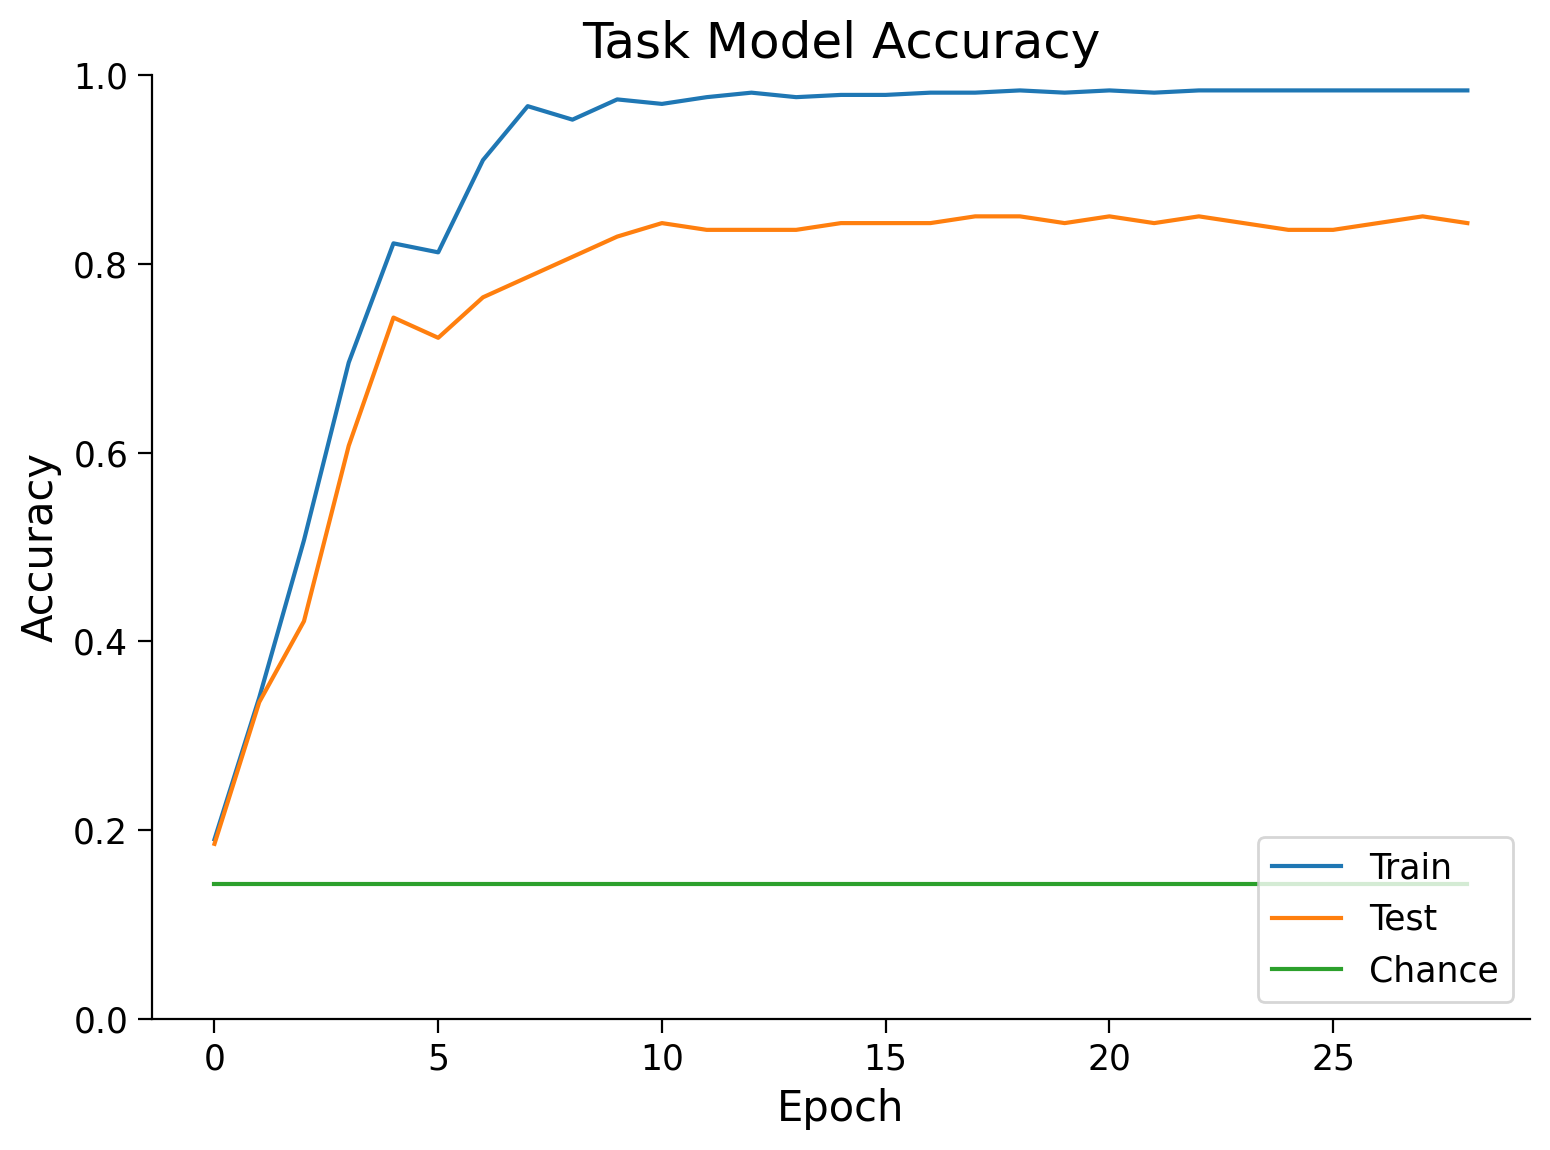

In [36]:
# @title Plot train/test accuracy over epochs
import matplotlib.pyplot as plt

xs = [x for x in range(len(train_acc_plot))]
chance = [1/7] * len(xs)

plt1 = plt.plot(xs, train_acc_plot)
plt2 = plt.plot(xs, test_acc_plot)
plt3 = plt.plot(xs, chance)
plt.ylim([0, 1])
plt.legend(('Train','Test','Chance'), loc='lower right')
plt.title('Task Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

testing...........
Test Acc: 0.8285714, Test Loss: 0.7883373 
Namespace(epoch=0, n_epochs=100, batchSize=50, dataroot='drive/MyDrive/NMA', fold=0, lr=0.01, stepsize=20, gamma=0.5, weightdecay=0.005, lamb0=1, lamb1=0, lamb2=0, lamb3=0.1, lamb4=0.1, lamb5=0.1, layer=7, ratio=0.5, indim=360, nroi=360, nclass=7, load_model=False, save_model=False, optim='Adam', save_path='./model/')
Confusion matrix
              precision    recall  f1-score   support

           0       0.78      0.90      0.84        20
           1       0.68      0.75      0.71        20
           2       0.82      0.90      0.86        20
           3       0.76      0.80      0.78        20
           4       0.89      0.85      0.87        20
           5       0.93      0.70      0.80        20
           6       1.00      0.90      0.95        20

    accuracy                           0.83       140
   macro avg       0.84      0.83      0.83       140
weighted avg       0.84      0.83      0.83       140



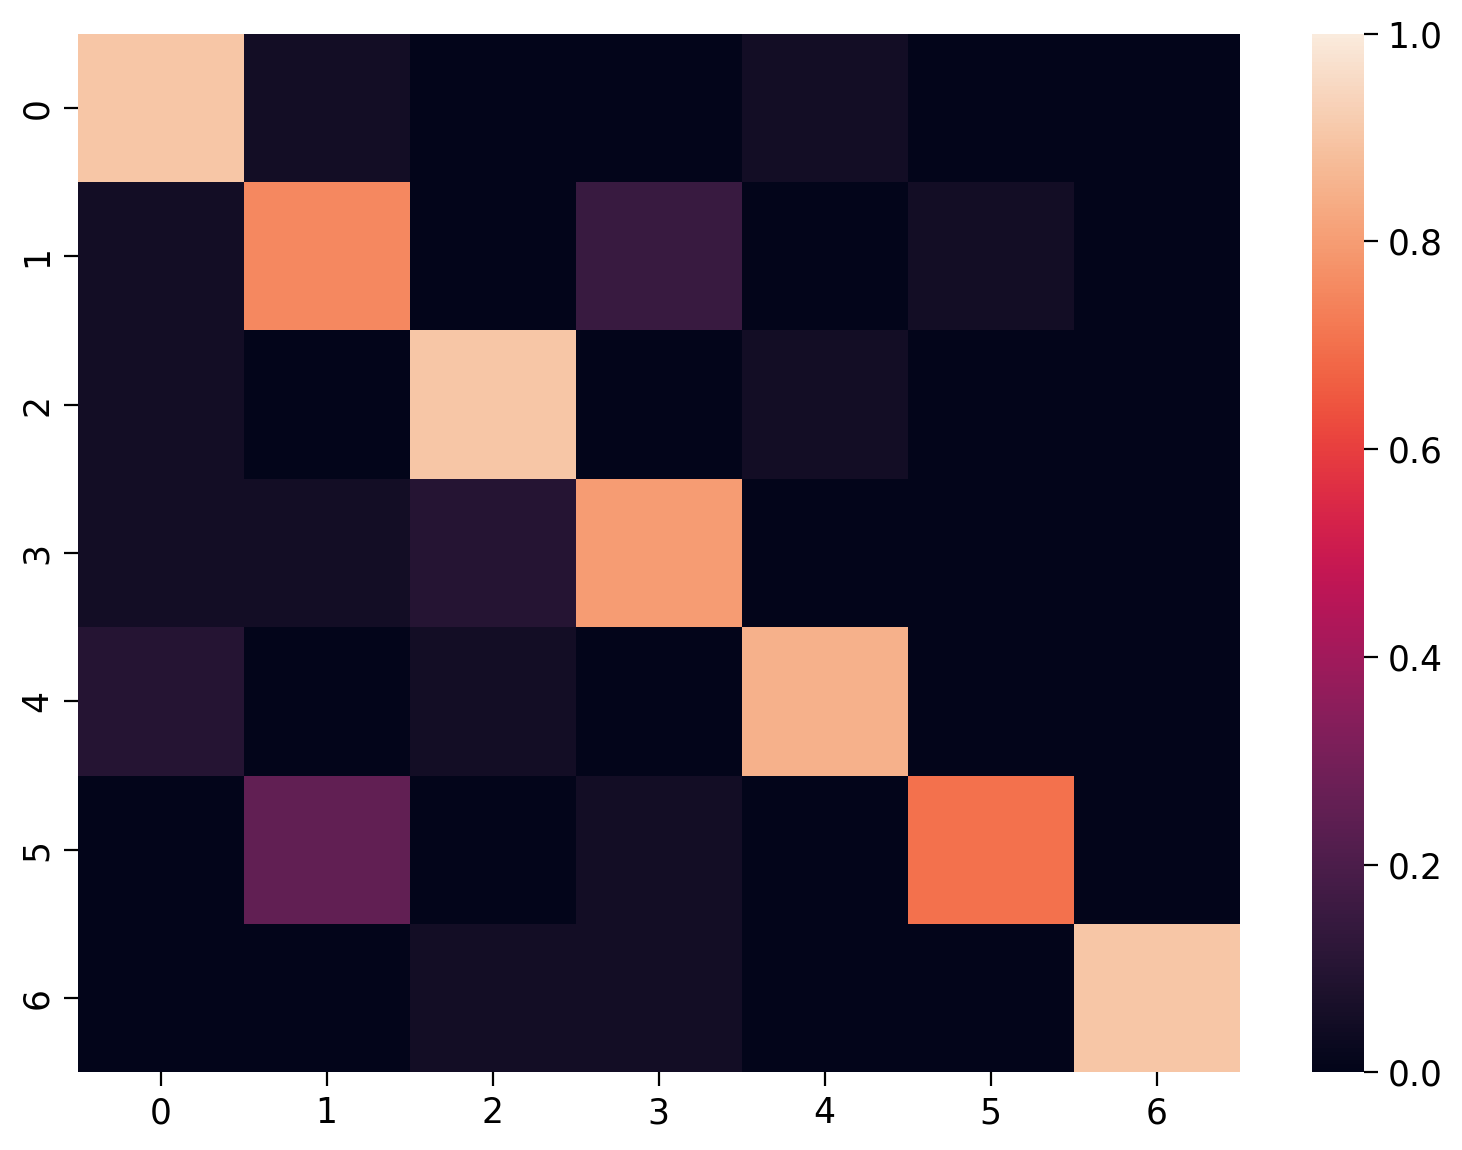

In [37]:
# @title Testing on held out data; make confusion matrix
if opt.load_model:
    model = Network(opt.indim,opt.ratio,opt.nclass).to(device)
    model.load_state_dict(torch.load(os.path.join(opt.save_path,str(fold)+'.pth')))
    model.eval()
    preds = []
    correct = 0
    for data in val_loader:
        data = data.to(device)
        outputs= model(data.x, data.edge_index, data.batch, data.edge_attr,data.pos)
        pred = outputs[0].max(1)[1]
        preds.append(pred.cpu().detach().numpy())
        correct += pred.eq(data.y).sum().item()
    preds = np.concatenate(preds,axis=0)
    trues = val_dataset.data.y.cpu().detach().numpy()
    cm = confusion_matrix(trues,preds)
    print("Confusion matrix")
    print(classification_report(trues, preds))

else:
   model.load_state_dict(best_model_wts)
   model.eval()
   test_accuracy = test_acc(test_loader)
   test_l= test_loss(test_loader,0)
   print("===========================")
   print("Test Acc: {:.7f}, Test Loss: {:.7f} ".format(test_accuracy, test_l))
   print(opt)

   preds = []
   trues = []
   correct = 0
   for data in test_loader:
      data = data.to(device)
      outputs= model(data.x, data.edge_index, data.batch, data.edge_attr,data.pos)
      pred = outputs[0].max(1)[1]
      preds.append(pred.cpu().detach().numpy())
      correct += pred.eq(data.y).sum().item()
      true_pull = data.y.cpu().detach().numpy()
      trues.append(true_pull)
   trues = np.concatenate(trues,axis=0)
   preds = np.concatenate(preds,axis=0)
   cm = confusion_matrix(trues,preds)
   print("Confusion matrix")
   print(classification_report(trues, preds))
   ax = sns.heatmap(cm/(len(test_dataset)/7), vmin=0, vmax=1)
   plt.show()